In [1]:
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from pathlib import Path
import tqdm
import glob
import numpy as np
import hvplot.xarray
import datetime as dt
import pandas as pd
import pyproj
from IPython.display import Video, Image

#We will also use 'xmovie', but import that later otherwise it messes with plotting
#import xmovie

In [2]:
#Start up a dask client
client = Client()

In [3]:
client

<Client: 'tcp://127.0.0.1:37965' processes=4 threads=4, memory=18.00 GiB>

# 1) Using ImageMagick

To visualise ACCESS-rAM3 model output - provided by Mat Lipson, details on [GitHub](https://github.com/21centuryweather/RNS_Sydney_1km)

### Load rAM3 output

Hourly output for January 2017 has been copied to the `gb02` project. This includes two variables:

* `upward_air_velocity`
* `wind_speed_of_gust`

For three [domains](https://github.com/21centuryweather/RNS_Sydney_1km#domains):

* `12p2` (km grid spacing)
* `5` (km grid spacing)
* `1` (km grid spacing)


We will load wind gust data from the 12p2 km domain. You can change the code to the other domains but it will be slower. Can also try plotting `upward_air_velocity`. 

In [4]:
#Load the wind gust data for the whole month. Use the same chunks as on disk (time=1,lat=-1,lon=-1)
wind_gust = xr.open_dataset("/g/data/gb02/ab4502/animation_demo/data/ram3_201701/BR2_12p2_CCI_wind_gust.nc",chunks={})

#Slice it down in time
wind_gust = wind_gust.sel(time=slice("2017-01-27 00:00","2017-01-28 23:00"))

### Define our plotting function

Say we want to plot the evolution of the wind gust field through time. Define the plot for a single time step

Test it out by plotting the first time step

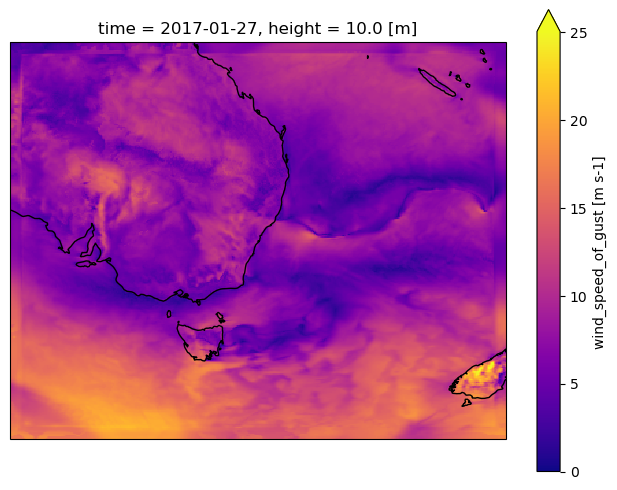

In [5]:
def plot_gust(ax,da):
    '''
    ax: pyplot axes to plot on
    ds: Xarray dataarray with lat lon dims (single time step)
    '''

    #Plot the wind gust. We want to manually define the colorbar extent (vmin, vmax, extend) so that it doesn't change through
    # the animation
    da.plot(ax=ax,vmin=0,vmax=25,extend="max",cmap="plasma")

#Open a new figure
fig = plt.figure(figsize=[8,6])

#Create new pyplot axis. Setting a cartopy projection makes it a "geoaxes", which has knows about coastlines
ax=plt.axes(projection=ccrs.PlateCarree())

#Run the plotting function for a single timestep
plot_gust(ax, wind_gust.wind_speed_of_gust.isel(time=0))

#Draw the coastline
ax.coastlines()

Now we can loop over all the time steps, and save plots to disk

This could probably be done with the [matplotlib animation classes](https://matplotlib.org/stable/api/animation_api.html) but I found it more complicated

In [6]:
#Set up paths to save figures 

#Define output path 
SCRATCH_DIR = Path('/scratch')
DUMP_DIR = SCRATCH_DIR / os.environ["PROJECT"] / os.environ["USER"] / 'temp_figs'

#Create the directory if it doesn't already exist
if os.path.isdir(DUMP_DIR):
    #Remove previous figures and animations
    [os.remove(f) for f in glob.glob(f'{DUMP_DIR}/*.png')]
    [os.remove(f) for f in glob.glob(f'{DUMP_DIR}/*.gif')]
    [os.remove(f) for f in glob.glob(f'{DUMP_DIR}/*.mp4')]
else:
    os.mkdir(DUMP_DIR)



In [7]:
#Loop over time steps in the dataset
for t in tqdm.tqdm(np.arange(wind_gust.time.shape[0])):

    #As before, but for time, t
    fig = plt.figure(figsize=[8,6])
    ax=plt.axes(projection=ccrs.PlateCarree())
    plot_gust(ax, wind_gust.wind_speed_of_gust.isel(time=t))
    ax.coastlines()

    #Save the plot to disk in time order
    plt.savefig(f'{DUMP_DIR}/{str(t).zfill(3)}.png')

    #Don't forget to close the figure or else we will open a lot of them
    plt.close(fig)

100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


In [8]:
print(DUMP_DIR)

/scratch/ng72/ab4502/temp_figs


In [9]:
#Use imagemagick to combine png files into an animation

#Can run the below in a terminal, or by using "!" in a notebook
#Will create ram3_animation.gif in the same directory as the temp .png figs by default
#Delay controls the speed of the animation
#Loop controls how many loop iterations

cmd = f'convert -delay 20 -loop 20 {DUMP_DIR}/*.png {DUMP_DIR}/ram3_animation.gif'
!$cmd

# 2) hvplot

To visualise the same ram3 data

* hvplot allows you to group xarray datasets and step through it as an animation

* hvplot is a nice interactive tool for static images, too (allows for hovering, zooming)

* https://hvplot.holoviz.org/en/docs/latest/user_guide/Gridded_Data.html#

* **NOTE** animations only worked for me with previous versions of `analysis3` (24.12)

In [10]:
wind_gust["wind_speed_of_gust"].hvplot(
    x="longitude",
    y="latitude",
    groupby="time",
    clim=(0, 25),
    width=800,
    height=600,
    widget_type='scrubber',
    widget_location='bottom',
    coastline=True,
    crs=ccrs.PlateCarree(),
    persist=True,
    cmap="plasma",
    rasterize=True)

Column
    [0] HoloViews(DynamicMap, height=600, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber', width=800)
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=47, width=550)

Doesn't have to be a spatial map! You can animate in any dimension. This could animate through temperature time series with longitudes (fixed at 30$\degree$S)

In [11]:
wind_gust["wind_speed_of_gust"].sel(latitude=-30,method="nearest").hvplot(
    groupby="longitude",
    ylim=[0,30],
    widget_type='scrubber',
    widget_location='bottom')

Column
    [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber', width=700)
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=361, width=550)

# 3) xmovie

To visualise some Himawari satellite data (has been copied from the `ra22` project to the `gb02` project)

* https://xmovie.readthedocs.io/en/latest/
(no longer maintained 😞)

* Can create figures in parallel and then save together in a single animation

* Is useful for creating large animations fast (and should work on data that doesn't fit in memory)

* Similar to method (1), but with the potential speed up, and need to specially configure the plotting function to work in xmovie

## Import xmovie

In [12]:
import xmovie

## Load data for chosen times and x/y domain

In [13]:
#Settings for amination

#Time bounds
t1 = "2016-09-27 22:00"
t2 = "2016-09-28 08:00"

#Time step (data is 10-minute)
step = "30min"

#Domain bounds (in himawari data projection)
x_slice = slice(-1988250., -52750.)
y_slice = slice(-2600250., -4245250.)

#Define function to load himawari data
def load_hima(datetime,x_slice=slice(-3e6,2e6),y_slice=slice(-1e6,-4.5e6)):

    """
    Load Himawari data for a given time slice. The default x and y slices correspond to
    mainland Australia
    """

    #To load directly from ra22 (if you are a member and have added the gdata/ra22 storage flag to your ARE session)
    # fname = "/g/data/ra22/satellite-products/arc/obs/himawari-ahi/fldk/latest/"+\
    #                       datetime.strftime("%Y")+"/"+\
    #                       datetime.strftime("%m")+"/"+\
    #                       datetime.strftime("%d")+"/"+\
    #                       datetime.strftime("%H%M")+"/"+\
    #                       datetime.strftime("%Y%m%d%H%M%S")+\
    #                       "-P1S-ABOM_CREFL_B03-PRJ_GEOS141_500-HIMAWARI*-AHI.nc"

    #Load a single time slice of Himawari data (from sample data in gb02, copied from ra22)
    fname = "/g/data/gb02/ab4502/animation_demo/data/himawari_201609/"+\
                          datetime.strftime("%Y%m%d%H%M%S")+\
                          "-P1S-ABOM_CREFL_B03-PRJ_GEOS141_500-HIMAWARI*-AHI.nc"    
    ds = xr.open_mfdataset(fname,chunks={"x":-1,"y":-1})

    #Define geostationary projection from file metadata projections firstly with cartopy then pyproj
    ccrs_proj = ccrs.Geostationary(
        central_longitude=ds["geostationary"].attrs["longitude_of_projection_origin"],
        satellite_height=35785863)
    pyproj_proj = pyproj.Proj(ccrs_proj)

    #Slice the dataset in x-y space. The defaults here roughly correspond to mainland Australia
    ds = ds.sel(x=x_slice,y=y_slice)
    
    return ds, pyproj_proj, ccrs_proj

## Stack the dataset together for use in xmovie

Make sure the data is chunked only in time (with chunksize of 1). Otherwise use `.chunk()` to re-chunk

In [14]:
#Now load a series of times, for the smaller region of interest defined above

#Initialise list of himawari datasets
ds_list = []

#Loop over times from t1 to t2 with frequency step
for t in tqdm.tqdm(pd.date_range(t1,t2,freq=step)):
    temp_ds,proj,ccrs_proj = load_hima(t,x_slice = x_slice,y_slice = y_slice)
    ds_list.append(temp_ds)

#Concaternate the himawari datasets into one
ds_multiple_times = xr.concat(ds_list,"time")

100%|██████████| 21/21 [00:06<00:00,  3.28it/s]


In [15]:
ds_multiple_times

<xarray.Dataset> Size: 1GB
Dimensions:                             (time: 21, y: 3291, x: 3872)
Coordinates:
  * time                                (time) datetime64[ns] 168B 2016-09-27...
  * x                                   (x) float64 31kB -1.988e+06 ... -5.27...
  * y                                   (y) float64 26kB -2.6e+06 ... -4.245e+06
Data variables:
    channel_0003_corrected_reflectance  (time, y, x) float32 1GB dask.array<chunksize=(1, 3291, 3872), meta=np.ndarray>
    geostationary                       (time) float32 84B 9.969e+36 ... 9.96...
    scan_line_time                      (time, y) datetime64[ns] 553kB dask.array<chunksize=(1, 3291), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:                  See disclaimer
    cdm_data_type:                   grid
    comment:                         AGLS observations geometry product
    contributor_name:                Commonwealth of Australia, Bureau of Met...
    ...                              ...
    time_coverage_start:             20160927T220021Z
    wmo_platform_name:               Himawari-8
    wmo_satellite_number:            173
    history:                         Sat Oct 29 06:45:53 2022: ncatted -O -a ...
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    product_version:                 1.0

In [16]:
#For use in xmovie, each "frame" (in this case, time steps) should be chunk size of 1

ds_multiple_times.chunksizes 

Frozen({'time': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'y': (3291,), 'x': (3872,)})

## Set up plotting function 

As for the ACCESS-rAM3 animation, set up a plotting function. 

Xmovie does expect certain inputs and outputs (see `custom_plotfunc` here for how to properly configure your plotting function: https://xmovie.readthedocs.io/en/latest/examples/quickstart.html#User-provided)


In [17]:
def plot_hima(ds,fig,tt,framedim,proj):

    '''
    Required for xmovie
    ds: xarray dataset with spatial dims and "framedim" to be iterated over
    fig: Figure to plot on
    tt: Time index
    framedim: dim to iterate over

    Additional inputs I've invluded
    proj: Cartopy projection for satellite data (see ccrs_proj in load_hima())
    '''

    ax = plt.axes(projection=proj)
    c = ds.isel({framedim:tt}).plot(cmap="Greys_r",vmin=-0.2,vmax=1.5,ax=ax,add_colorbar=False)
    ax.set_title(ds.isel(time=tt).time.values)
    fig.colorbar(c,extend="both")
    ax.coastlines()
    ax.gridlines(draw_labels=["bottom","left"],ls=":")

    return None, None 
    # ^ This is not strictly necessary, but otherwise a warning will be raised.

In [18]:
#Create movie object
mov = xmovie.Movie(
    ds_multiple_times.channel_0003_corrected_reflectance,
    pixelwidth=1200,
    pixelheight=1200,
    plotfunc=plot_hima,
    proj=ccrs_proj,
    input_check=False,
    )

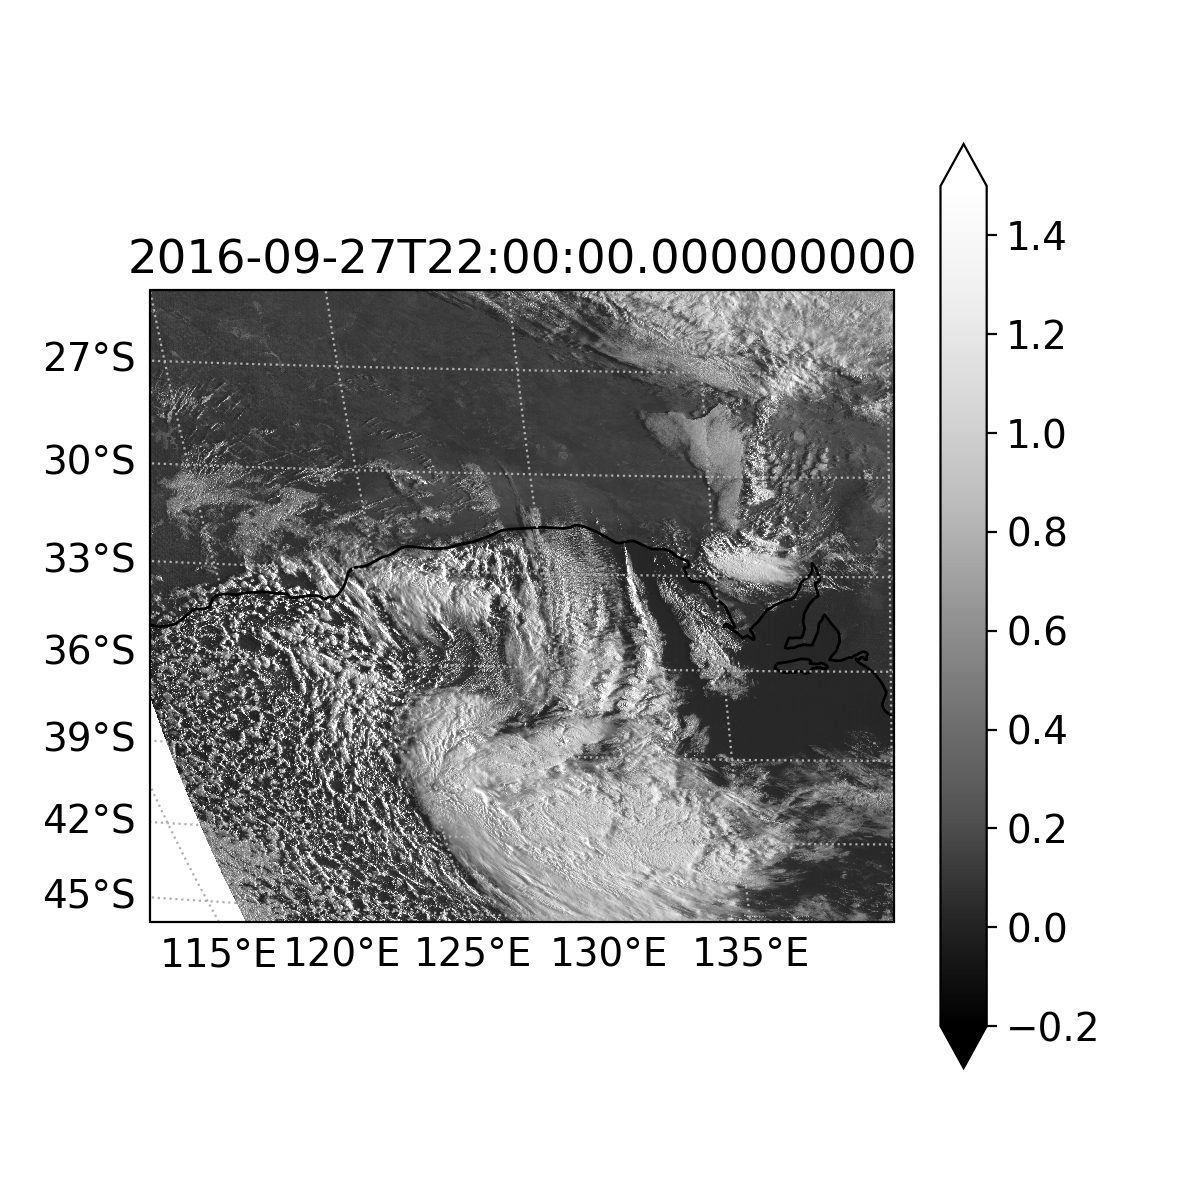

In [19]:
#Preview the first frame to check the plotting function.
#With xmovie loaded, figures don't seem to display - need to save it to disk and load it in
mov.preview(0)
plt.savefig(f'{DUMP_DIR}/sat_000.png')
Image(f'{DUMP_DIR}/sat_000.png')

In [20]:
#Save movie in scratch with the other animations
mov.save(
   f'{DUMP_DIR}/sat_{t1}_{t2}.mp4',
    overwrite_existing=True,
    parallel=True,
    progress=True,
    framerate=5) 

Movie created at sat_2016-09-27 22:00_2016-09-28 08:00.mp4


In [22]:
#Embed the video we made in the notebook
Video(filename=f'{DUMP_DIR}/sat_{t1}_{t2}.mp4',embed=True,width=800)